# Change the import of defragment to smotif

In [1]:
from collections import defaultdict
edges = defaultdict(int)
edges[(0,1)] = 1
edges[(1,2)] = 3
for a in edges:
        print(a[0],a[1],edges[a])
        print(edges[a])


0 1 1
1
1 2 3
3


In [2]:
import sys

In [3]:
from MotifGraph.MotitDcp.smotif_decompose import SMotifDecomposition


In [4]:
from jin_chemutils import *
import rdkit
import networkx as nx
from MotifGraph.MotitDcp.smotif_decompose import SMotifDecomposition
from rdkit import Chem
import networkx as nx

"""Build molecule graph"""

BOND_LIST = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC] 

def build_mol_graph(mol):
    graph = nx.DiGraph(Chem.rdmolops.GetAdjacencyMatrix(mol))
    for atom in mol.GetAtoms():
        graph.nodes[atom.GetIdx()]['label'] = (atom.GetSymbol(), atom.GetFormalCharge())

    for bond in mol.GetBonds():
        a1 = bond.GetBeginAtom().GetIdx()
        a2 = bond.GetEndAtom().GetIdx()
        btype = BOND_LIST.index( bond.GetBondType() )
        graph[a1][a2]['label'] = btype
        graph[a2][a1]['label'] = btype

    return graph

"""Build Tree_Graph"""

def find_clusters(mol):
    cliques, edges = SMotifDecomposition().defragment(mol)

    return list(cliques), edges


def tree_decomp(mol):
    clusters,edges  = find_clusters(mol)
    tree_graph = nx.empty_graph( len(clusters) )

    for edge in edges:
        tree_graph.add_edge(edge[0], edge[1], weight =edges[edge])
    n, m = len(tree_graph.nodes), len(tree_graph.edges)
    assert n - m <= 1 #must be connected
    return tree_graph if n - m == 1 else nx.maximum_spanning_tree(tree_graph)
    
    ##### 



def label_tree(mol):
    def dfs(order, pa, prev_sib, x, fa):
        pa[x] = fa 
        sorted_child = sorted([ y for y in mol_tree[x] if y != fa ]) #better performance with fixed order
        for idx,y in enumerate(sorted_child):
            mol_tree[x][y]['label'] = 0 
            mol_tree[y][x]['label'] = idx + 1 #position encoding
            prev_sib[y] = sorted_child[:idx] 
            prev_sib[y] += [x, fa] if fa >= 0 else [x]
            order.append( (x,y,1) )
            dfs(order, pa, prev_sib, y, x)
            order.append( (y,x,0) )
    
    mol_tree = nx.DiGraph(tree_decomp(mol))
    order, pa = [], {}
    clusters,_ = find_clusters(mol)
    prev_sib = [[] for i in range(len(clusters))]
    dfs(order, pa, prev_sib, 0, -1)

    order.append( (0, None, 0) ) #last backtrack at root
    
    graph = build_mol_graph(mol)
    for a in mol.GetAtoms():
        a.SetAtomMapNum( a.GetIdx() + 1 )

    for i,cls in enumerate(clusters):
        inter_atoms = set(cls) & set(clusters[pa[i]]) if pa[i] >= 0 else set([0])
        cmol, inter_label = get_inter_label(mol, cls, inter_atoms)
        mol_tree.nodes[i]['ismiles'] = ismiles = get_smiles(cmol)
        mol_tree.nodes[i]['inter_label'] = inter_label
        mol_tree.nodes[i]['smiles'] = smiles = get_smiles(set_atommap(cmol))
        mol_tree.nodes[i]['label'] = (smiles, ismiles) if len(cls) > 1 else (smiles, smiles)
        mol_tree.nodes[i]['cluster'] = cls 
        mol_tree.nodes[i]['assm_cands'] = []

        if pa[i] >= 0 and len(clusters[ pa[i] ]) > 2: #uncertainty occurs in assembly
            hist = [a for c in prev_sib[i] for a in clusters[c]] 
            pa_cls = clusters[ pa[i] ]
            mol_tree.nodes[i]['assm_cands'] = get_assm_cands(mol, hist, inter_label, pa_cls, len(inter_atoms)) 

            child_order = mol_tree[i][pa[i]]['label']
            diff = set(cls) - set(pa_cls)
            for fa_atom in inter_atoms:
                for ch_atom in graph[fa_atom]:
                    if ch_atom in diff:
                        label = graph[ch_atom][fa_atom]['label']
                        if type(label) is int: #in case one bond is assigned multiple times
                            graph[ch_atom][fa_atom]['label'] = (label, child_order)
    return order,mol_tree,graph

In [1]:
import networkx as nx
from rdkit import Chem
from typing import Tuple, List, Dict, Set
from MotifGraph.chemutils import get_inter_label, set_atommap, get_smiles, get_assm_cands
from MotifGraph.MotitDcp.smotif_decompose import SMotifDecomposition
from MotifGraph.MotitDcp.jin_decompose import TreeDecomposition
from MotifGraph.MotitDcp.brics_decompose import BRCISDecomposition
from MotifGraph.MotitDcp.motif_decompose import MotifDecomposition
class JTConstruct:
    def __init__(self, mol: Chem.Mol,
                 fragment_type: str = 'smotif'):
        """
        Initialize JTConstruct with a molecule.

        :param mol: RDKit Molecule object.
        """
        self.mol = mol
        self.fragment_type = fragment_type
        self.mol_tree = None
        self.graph = None
        self.order = None
        self.BOND_LIST = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, 
                          Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]
        

    @staticmethod
    def build_mol_graph(mol: Chem.Mol, bond_list: List[Chem.rdchem.BondType]) -> nx.DiGraph:
        """
        Constructs a molecular graph from the RDKit Molecule object.

        :param mol: RDKit Molecule object.
        :return: NetworkX Directed Graph representing the molecule.
        """
        graph = nx.DiGraph(Chem.rdmolops.GetAdjacencyMatrix(mol))
        for atom in mol.GetAtoms():
            graph.nodes[atom.GetIdx()]['label'] = (atom.GetSymbol(), atom.GetFormalCharge())

        for bond in mol.GetBonds():
            a1 = bond.GetBeginAtom().GetIdx()
            a2 = bond.GetEndAtom().GetIdx()
            btype = bond_list.index(bond.GetBondType())
            graph[a1][a2]['label'] = btype
            graph[a2][a1]['label'] = btype

        return graph

    @staticmethod
    def find_clusters(mol: Chem.Mol,
                      fragment_type: str = 'smotif') -> Tuple[List[Set[int]], Dict[Tuple[int, int], int]]:
        """
        Identifies clusters in the molecule.

        :param mol: RDKit Molecule object.
        :return: A tuple containing a list of clusters and edges.
        """
        if fragment_type == 'smotif':
            cliques, edges = SMotifDecomposition().defragment(mol)
            print(cliques)
        elif fragment_type == 'brics':
            cliques, edges = BRCISDecomposition().defragment(mol)
            print(cliques)
        elif fragment_type == 'motif':
            cliques, edges = MotifDecomposition().defragment(mol)
            print(cliques)
        elif fragment_type == 'jin':
            cliques, edges = TreeDecomposition().defragment(mol)
            print(cliques)
        return list(cliques), edges

    @staticmethod
    def tree_decomp(mol: Chem.Mol,
                    fragment_type: str = 'smotif') -> nx.Graph:
        """
        Performs tree decomposition on the molecule.

        :param mol: RDKit Molecule object.
        :return: NetworkX Graph representing the tree decomposition.
        """
        clusters, edges = JTConstruct.find_clusters(mol,  fragment_type)
        tree_graph = nx.empty_graph(len(clusters))

        for edge in edges:
            tree_graph.add_edge(edge[0], edge[1], weight=edges[edge])
        n, m = len(tree_graph.nodes), len(tree_graph.edges)
        assert n - m <= 1  # must be connected
        return tree_graph if n - m == 1 else nx.maximum_spanning_tree(tree_graph)

    @staticmethod
    def dfs(order: List[Tuple[int, int, int]], pa: Dict[int, int], prev_sib: List[List[int]],
            x: int, fa: int, mol_tree: nx.DiGraph):
        """
        Depth-first search for labeling tree nodes.

        :param order: Order of traversal.
        :param pa: Parent nodes.
        :param prev_sib: Previous siblings.
        :param x: Current node.
        :param fa: Parent of current node.
        :param mol_tree: NetworkX DiGraph of the molecule tree.
        """
        pa[x] = fa 
        sorted_child = sorted([ y for y in mol_tree[x] if y != fa ]) #better performance with fixed order
        for idx,y in enumerate(sorted_child):
            mol_tree[x][y]['label'] = 0 
            mol_tree[y][x]['label'] = idx + 1 #position encoding
            prev_sib[y] = sorted_child[:idx] 
            prev_sib[y] += [x, fa] if fa >= 0 else [x]
            order.append( (x,y,1) )
            JTConstruct.dfs(order, pa, prev_sib, y, x, mol_tree)
            order.append( (y,x,0) )

    def label_tree(self):
        """
        Labels the tree decomposed graph of the molecule.
        """
        self.mol_tree = nx.DiGraph(self.tree_decomp(self.mol, self.fragment_type))
        self.order, pa = [], {}
        clusters, _ = self.find_clusters(self.mol)
        prev_sib = [[] for _ in range(len(clusters))]
        self.dfs(self.order, pa, prev_sib, 0, -1, self.mol_tree)

        self.order.append((0, None, 0))  # last backtrack at root

        self.graph = self.build_mol_graph(self.mol, self.BOND_LIST)
        for a in self.mol.GetAtoms():
            a.SetAtomMapNum( a.GetIdx() + 1 )

        for i,cls in enumerate(clusters):
            inter_atoms = set(cls) & set(clusters[pa[i]]) if pa[i] >= 0 else set([0])
            cmol, inter_label = get_inter_label(self.mol, cls, inter_atoms)
            self.mol_tree.nodes[i]['ismiles'] = ismiles = get_smiles(cmol)
            self.mol_tree.nodes[i]['inter_label'] = inter_label
            self.mol_tree.nodes[i]['smiles'] = smiles = get_smiles(set_atommap(cmol))
            self.mol_tree.nodes[i]['label'] = (smiles, ismiles) if len(cls) > 1 else (smiles, smiles)
            self.mol_tree.nodes[i]['cluster'] = cls 
            self.mol_tree.nodes[i]['assm_cands'] = []

            if pa[i] >= 0 and len(clusters[ pa[i] ]) > 2: #uncertainty occurs in assembly
                hist = [a for c in prev_sib[i] for a in clusters[c]] 
                pa_cls = clusters[ pa[i] ]
                self.mol_tree.nodes[i]['assm_cands'] = get_assm_cands(self.mol, hist, inter_label, pa_cls, len(inter_atoms)) 

                child_order = self.mol_tree[i][pa[i]]['label']
                diff = set(cls) - set(pa_cls)
                for fa_atom in inter_atoms:
                    for ch_atom in self.graph[fa_atom]:
                        if ch_atom in diff:
                            label = self.graph[ch_atom][fa_atom]['label']
                            if type(label) is int: #in case one bond is assigned multiple times
                                self.graph[ch_atom][fa_atom]['label'] = (label, child_order)
        return self.order, self.mol_tree, self.graph



ImportError: cannot import name 'RDLogger' from 'rdkit.Chem' (/opt/homebrew/Caskroom/miniforge/base/envs/MotifGraph/lib/python3.11/site-packages/rdkit/Chem/__init__.py)

In [3]:
from rdkit import RDLogger

In [6]:
smiles = "CN1C2CCC1CC(C2)OC(=O)C(CO)c3ccccc3"   #have_bond_merge
mol = Chem.MolFromSmiles(smiles)
order,mol_tree,graph = JTConstruct(mol, 'smotif').label_tree()

[[0, 1], [13, 14], [9, 7], [9, 10, 11, 12, 13, 15], {1, 2, 3, 4, 5, 6, 7, 8}, {15, 16, 17, 18, 19, 20}]
[[0, 1], [13, 14], [9, 7], [9, 10, 11, 12, 13, 15], {1, 2, 3, 4, 5, 6, 7, 8}, {15, 16, 17, 18, 19, 20}]


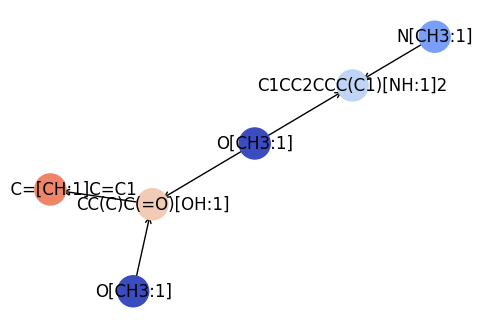

In [14]:
from MotifGraph.JunctionTree.jt_vis import tree_vis, vis_compare
tree = tree_vis(mol_tree, edge_labels=False, seed=42, show_clusters=True, figsize=(6,4))

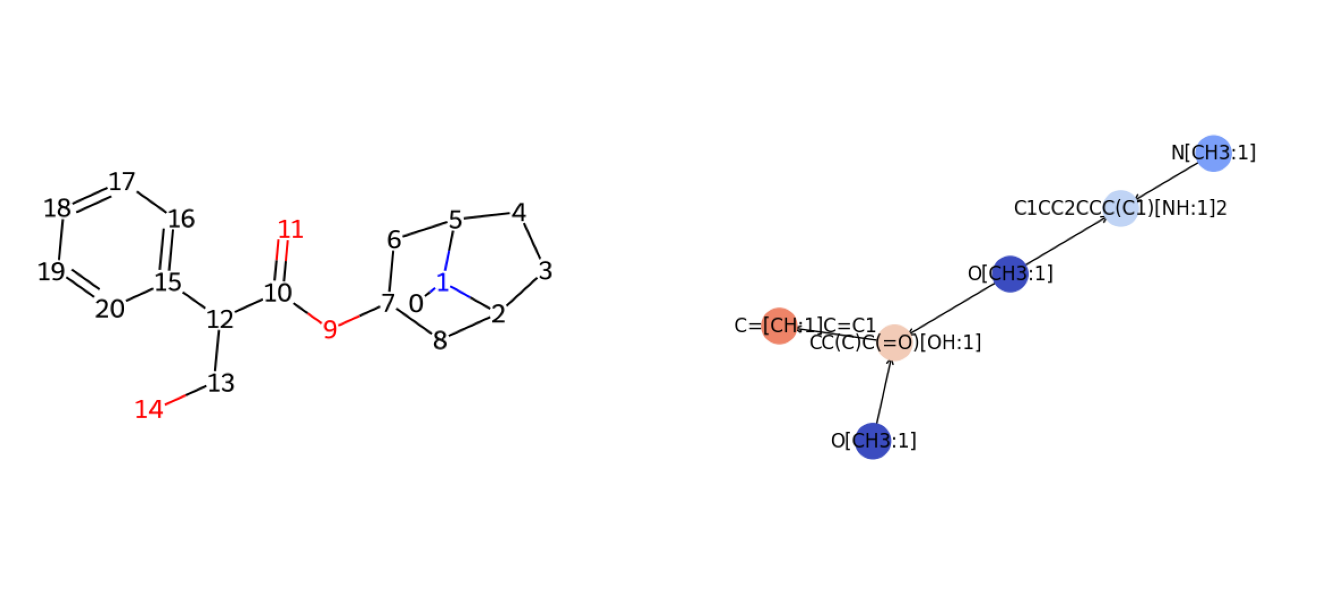

In [15]:
vis_compare(smiles, tree, figsize=(14, 6))

In [ ]:
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
import io

def vis_compare(smiles, tree_nodes_fig, show_atom_map=True, figsize=(10, 6), mol_img_size=(500, 500)):
    """
    Create a 1x2 subplot with a molecule structure from a SMILES string and a tree nodes figure.

    Parameters:
    - smiles (str): A SMILES string representing a molecule.
    - tree_nodes_fig (plt.Figure): A matplotlib figure representing tree nodes.
    - show_atom_map (bool): If True, shows atom map numbers on the molecule.
    - figsize (tuple): Size of the entire subplot figure.
    - mol_img_size (tuple): Size of the molecule image.
    """
    # Create a subplot layout
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Generate a molecule from the SMILES string
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        if show_atom_map:
            for atom in mol.GetAtoms():
                atom.SetProp('atomLabel', str(atom.GetIdx()))
        # Convert the RDKit drawing to an image
        mol_img = Draw.MolToImage(mol, size=mol_img_size)
        # Display the molecule image in the first subplot
        axes[0].imshow(mol_img)
        axes[0].axis('off')  # Turn off axis for molecule image

    # Display the tree nodes figure in the second subplot
    buf = io.BytesIO()
    tree_nodes_fig.savefig(buf, format='png')
    buf.seek(0)
    img = plt.imread(buf)
    axes[1].imshow(img)
    axes[1].axis('off')  # Turn off axis for tree nodes figure

    # Add a gridline to separate the subfigures
    plt.subplots_adjust(wspace=0.5)

    plt.tight_layout()
    plt.show()




visualize_smiles_and_tree(smiles, tree)

In [ ]:
from MotifGraph.JunctionTree.jt_vis import tree_vis
tree_vis(mol_tree, edge_labels=False, seed=42, show_clusters=False)

## PLEASE DO NOT LOOK DOWN HERE

In [ ]:
import rdkit
import networkx as nx
from rdkit import Chem
BOND_LIST = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC] 
smiles = "CN1C2CCC1CC(C2)OC(=O)C(CO)c3ccccc3"   #have_bond_merge


mol = Chem.MolFromSmiles(smiles)
mol2 = mol
for atom in mol2.GetAtoms():
    # For each atom, set the property "atomNote" to a index+1 of the atom
    atom.SetProp("atomNote", str(atom.GetIdx()))

display(mol2)
a = Chem.rdmolops.GetAdjacencyMatrix(mol)
print(a.shape)

In [ ]:
molgraph = MolGraph("CN1C2CCC1CC(C2)OC(=O)C(CO)c3ccccc3")
clusters = molgraph.clusters
edges = molgraph.edges
print(edges)
mol_graph = molgraph.mol_graph
print("CLUSTER",clusters)
# print("Atom in cluster",atom_cls)

graph = nx.empty_graph( len(clusters) )
# for atom, nei_cls in enumerate(atom_cls):
    # if len(nei_cls) <= 1: continue
    # bonds = [c for c in nei_cls if len(clusters[c]) == 2]
    # rings = [c for c in nei_cls if len(clusters[c]) > 4] #need to change to 2

    # if len(nei_cls) > 2 and len(bonds) >= 2:
    #     clusters.append([atom])
    #     c2 = len(clusters) - 1
    #     graph.add_node(c2)
    #     for c1 in nei_cls:
    #         graph.add_edge(c1, c2, weight = 100)

    # elif len(rings) > 2: #Bee Hives, len(nei_cls) > 2 
    #     clusters.append([atom]) #temporary value, need to change
    #     c2 = len(clusters) - 1
    #     graph.add_node(c2)
    #     for c1 in nei_cls:
    #         graph.add_edge(c1, c2, weight = 100)
    # else:
        # for i,c1 in enumerate(nei_cls):
        #     for c2 in nei_cls[i + 1:]:
        #         inter = set(clusters[c1]) & set(clusters[c2])
        #         graph.add_edge(c1, c2, weight = len(inter))
print("EDGEs",edges)
for edge in edges:
    print(edge[0],edge[1],edges[edge])
    graph.add_edge(edge[0], edge[1], weight = edges[edge])

print("Prev NODES",graph.nodes)
print("Prev EDGE", graph.edges)
n, m = len(graph.nodes), len(graph.edges)
# assert n - m <= 1 #must be connected
if n - m == 1: print(f'Graph fully connected',graph) 
else: 
    print(f"graph is not fully connected", nx.maximum_spanning_tree(graph))
    graph = nx.maximum_spanning_tree(graph)
    print("Later NODES",graph.nodes)
    print("Later EDGE", graph.edges)
for i in graph.edges:
    print(f"edge index {i}:", graph.edges[i])
nx.draw(graph,with_labels=True, font_weight='bold')


In [ ]:
mol_tree = nx.DiGraph(graph)
nx.draw(mol_tree,with_labels=True, font_weight='bold')


In [ ]:
nx.draw(mol_graph,with_labels=True, font_weight='bold')


In [ ]:
def dfs(mol_graph,mol_tree,order, pa, prev_sib, x, fa):
    print(f"Searching node {x} with parent node is {fa}")
    # print("child contain", mol_tree[x])
    pa[x] = fa 
    sorted_child = sorted([ y for y in mol_tree[x] if y != fa ]) #better performance with fixed order
    # print("Children of this node", sorted_child) 
    for idx,y in enumerate(sorted_child):
        mol_tree[x][y]['label'] = 0 
        mol_tree[y][x]['label'] = idx + 1 #position encoding
        prev_sib[y] = sorted_child[:idx] 
        prev_sib[y] += [x, fa] if fa >= 0 else [x]
        order.append( (x,y,1) )
        dfs(mol_graph,mol_tree,order, pa, prev_sib, y, x)
        order.append( (y,x,0) )

order, pa = [], {}
mol_tree = nx.DiGraph(graph)
prev_sib = [[] for i in range(len(clusters))]
dfs(mol_graph,mol_tree,order, pa, prev_sib, 0, -1)
order.append( (0, None, 0) ) #last backtrack at root
print("final order", order)
print("dict pa contain:",pa)
print("previous sibling:", prev_sib)

mol = Chem.MolFromSmiles("CN1C2CCC1CC(C2)OC(=O)C(CO)c3ccccc3")
Chem.Kekulize(mol)

for a in mol.GetAtoms():
    a.SetAtomMapNum( a.GetIdx() + 1 )
display(mol)

tree = mol_tree
for i,cls in enumerate(clusters):
    inter_atoms = set(cls) & set(clusters[pa[i]]) if pa[i] >= 0 else set([0])
    print(f"*****Cluster {i}",cls)
    print("parent node", pa[i], clusters[pa[i]])
    print("inter_atom:",inter_atoms)
    cmol, inter_label = get_inter_label(mol, cls, inter_atoms)                      #chemutils
    tree.nodes[i]['ismiles'] = ismiles = get_smiles(cmol)
    tree.nodes[i]['inter_label'] = inter_label
    tree.nodes[i]['smiles'] = smiles = get_smiles(set_atommap(cmol))
    tree.nodes[i]['label'] = (smiles, ismiles) if len(cls) > 1 else (smiles, smiles)
    tree.nodes[i]['cluster'] = cls 
    tree.nodes[i]['assm_cands'] = []

    if pa[i] >= 0 and len(clusters[ pa[i] ]) > 2: #uncertainty occurs in assembly                       
        hist = [a for c in prev_sib[i] for a in clusters[c]]                       
        print("="*10 + f"HIST " + f"{hist}" + "="*10)
        pa_cls = clusters[ pa[i] ]
        tree.nodes[i]['assm_cands'] = get_assm_cands(mol, hist, inter_label, pa_cls, len(inter_atoms)) 

        child_order = tree[i][pa[i]]['label']
        diff = set(cls) - set(pa_cls)
        for fa_atom in inter_atoms:
            for ch_atom in mol_graph[fa_atom]:
                if ch_atom in diff:
                    label = mol_graph[ch_atom][fa_atom]['label']
                    if type(label) is int: #in case one bond is assigned multiple times
                        mol_graph[ch_atom][fa_atom]['label'] = (label, child_order)
    # print(tree.nodes[i])
for i in range(0,len(mol_graph.adj)):
    print(f"node {i}",mol_graph.nodes[i])


In [ ]:
for i in mol_tree.nodes:
    print("="*5 + f"This is node {i}")
    print(mol_tree.nodes[i])

In [ ]:
mol_tree.nodes[1]

In [ ]:
import rdkit
import rdkit.Chem as Chem
from collections import defaultdict

lg = rdkit.RDLogger.logger() 
lg.setLevel(rdkit.RDLogger.CRITICAL)

idxfunc = lambda a : a.GetAtomMapNum() - 1

def set_atommap(mol, num=0):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(num)
    return mol

def get_mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None: Chem.Kekulize(mol)
    return mol

def get_smiles(mol):
    return Chem.MolToSmiles(mol, kekuleSmiles=True)

def sanitize(mol, kekulize=True):
    try:
        smiles = get_smiles(mol) if kekulize else Chem.MolToSmiles(mol)
        mol = get_mol(smiles) if kekulize else Chem.MolFromSmiles(smiles)
    except:
        mol = None
    return mol

def is_aromatic_ring(mol):
    if mol.GetNumAtoms() == mol.GetNumBonds(): 
        aroma_bonds = [b for b in mol.GetBonds() if b.GetBondType() == Chem.rdchem.BondType.AROMATIC]
        return len(aroma_bonds) == mol.GetNumBonds()
    else:
        return False

def get_leaves(mol):
    leaf_atoms = [atom.GetIdx() for atom in mol.GetAtoms() if atom.GetDegree() == 1]

    clusters = []
    for bond in mol.GetBonds():
        a1 = bond.GetBeginAtom().GetIdx()
        a2 = bond.GetEndAtom().GetIdx()
        if not bond.IsInRing():
            clusters.append( set([a1,a2]) )

    rings = [set(x) for x in Chem.GetSymmSSSR(mol)]
    clusters.extend(rings)

    leaf_rings = []
    for r in rings:
        inters = [c for c in clusters if r != c and len(r & c) > 0]
        if len(inters) > 1: continue
        nodes = [i for i in r if mol.GetAtomWithIdx(i).GetDegree() == 2]
        leaf_rings.append( max(nodes) )

    return leaf_atoms + leaf_rings

def atom_equal(a1, a2):
    return a1.GetSymbol() == a2.GetSymbol() and a1.GetFormalCharge() == a2.GetFormalCharge()

def bond_match(mol1, a1, b1, mol2, a2, b2):
    a1,b1 = mol1.GetAtomWithIdx(a1), mol1.GetAtomWithIdx(b1)
    a2,b2 = mol2.GetAtomWithIdx(a2), mol2.GetAtomWithIdx(b2)
    return atom_equal(a1,a2) and atom_equal(b1,b2)

def copy_atom(atom, atommap=True):
    new_atom = Chem.Atom(atom.GetSymbol())
    new_atom.SetFormalCharge(atom.GetFormalCharge())
    if atommap: 
        new_atom.SetAtomMapNum(atom.GetAtomMapNum())
    return new_atom

#mol must be RWMol object
def get_sub_mol(mol, sub_atoms):
    new_mol = Chem.RWMol()
    atom_map = {}
    for idx in sub_atoms:
        atom = mol.GetAtomWithIdx(idx)
        atom_map[idx] = new_mol.AddAtom(atom)

    sub_atoms = set(sub_atoms)
    for idx in sub_atoms:
        a = mol.GetAtomWithIdx(idx)
        for b in a.GetNeighbors():
            if b.GetIdx() not in sub_atoms: continue
            bond = mol.GetBondBetweenAtoms(a.GetIdx(), b.GetIdx())
            bt = bond.GetBondType()
            if a.GetIdx() < b.GetIdx(): #each bond is enumerated twice
                new_mol.AddBond(atom_map[a.GetIdx()], atom_map[b.GetIdx()], bt)

    return new_mol.GetMol()

def copy_edit_mol(mol):
    new_mol = Chem.RWMol(Chem.MolFromSmiles(''))
    for atom in mol.GetAtoms():
        new_atom = copy_atom(atom)
        new_mol.AddAtom(new_atom)

    for bond in mol.GetBonds():
        a1 = bond.GetBeginAtom().GetIdx()
        a2 = bond.GetEndAtom().GetIdx()
        bt = bond.GetBondType()
        new_mol.AddBond(a1, a2, bt)
        #if bt == Chem.rdchem.BondType.AROMATIC and not aromatic:
        #    bt = Chem.rdchem.BondType.SINGLE
    return new_mol

def get_clique_mol(mol, atoms):
    smiles = Chem.MolFragmentToSmiles(mol, atoms, kekuleSmiles=True)
    new_mol = Chem.MolFromSmiles(smiles, sanitize=False)
    new_mol = copy_edit_mol(new_mol).GetMol()
    new_mol = sanitize(new_mol) 
    #if tmp_mol is not None: new_mol = tmp_mol
    return new_mol

def get_assm_cands(mol, atoms, inter_label, cluster, inter_size):
    atoms = list(set(atoms))
    mol = get_clique_mol(mol, atoms)
    atom_map = [idxfunc(atom) for atom in mol.GetAtoms()]
    display(mol)
    mol = set_atommap(mol)
    rank = Chem.CanonicalRankAtoms(mol, breakTies=False)
    rank = { x:y for x,y in zip(atom_map, rank) }
    print("ranking",rank)

    pos, icls = zip(*inter_label)
    print(f"Position {pos} and corresponding cluster {icls}")
    if inter_size == 1:
        print("Only one atom in inter_label, which is:", inter_label)
        cands = [pos[0]] + [ x for x in cluster if rank[x] != rank[pos[0]] ] 
    elif icls[0] == icls[1]: #symmetric case
        print(f"Symmetric case between {icls[0]} and {icls[1]}")
        shift = cluster[inter_size - 1:] + cluster[:inter_size - 1]
        print(f"Cluster is {cluster} then shift to {shift}")
        cands = zip(cluster, shift)
        # print(cands[0], cands[1])
        cands = [pos] + [ (x,y) for x,y in cands if (rank[min(x,y)],rank[max(x,y)]) != (rank[min(pos)], rank[max(pos)]) ]
    else: 
        shift = cluster[inter_size - 1:] + cluster[:inter_size - 1]
        cands = zip(cluster + shift, shift + cluster)
        cands = [pos] + [ (x,y) for x,y in cands if (rank[x],rank[y]) != (rank[pos[0]], rank[pos[1]]) ]
    print("Assemble Cands: ",cands)
    return cands

def get_inter_label(mol, atoms, inter_atoms):
    new_mol = get_clique_mol(mol, atoms)
    if new_mol.GetNumBonds() == 0: 
        inter_atom = list(inter_atoms)[0]
        for a in new_mol.GetAtoms():
            a.SetAtomMapNum(0)
        return new_mol, [ (inter_atom, Chem.MolToSmiles(new_mol)) ]

    inter_label = []
    for a in new_mol.GetAtoms():
        idx = idxfunc(a)
        if idx in inter_atoms and is_anchor(a, inter_atoms):
            inter_label.append( (idx, get_anchor_smiles(new_mol, idx)) )

    for a in new_mol.GetAtoms():
        a.SetAtomMapNum( 1 if idxfunc(a) in inter_atoms else 0 )
    return new_mol, inter_label

def is_anchor(atom, inter_atoms):
    for a in atom.GetNeighbors():
        if idxfunc(a) not in inter_atoms:
            return True
    return False
            
def get_anchor_smiles(mol, anchor, idxfunc=idxfunc):
    copy_mol = Chem.Mol(mol)
    for a in copy_mol.GetAtoms():
        idx = idxfunc(a)
        if idx == anchor: a.SetAtomMapNum(1)
        else: a.SetAtomMapNum(0)

    return get_smiles(copy_mol)
